In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [12]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///./Resources/hawaii.sqlite")

In [15]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare (engine, reflect = True)

In [17]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [18]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [20]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [38]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
year2014 = calc_temps('2014-01-01', '2014-12-31')
print(year2014)

[(56.0, 73.26453600308048, 85.0)]


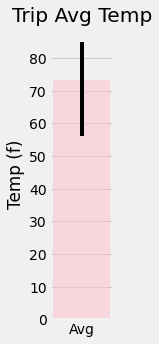

In [39]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(1,5))
plt.title('Trip Avg Temp')
plt.bar('Avg',year2014[0][1],width=0.005,color='pink',alpha=0.5)
plt.vlines('Avg',year2014[0][0],year2014[0][2],colors='black')
plt.ylabel('Temp (f)')
plt.grid(axis='x')
plt.savefig('Images/Trip Avg Temp.png',bbox_inches='tight')

### Daily Rainfall Average

In [42]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

session.query(station.name, func.sum(measurement.prcp), station.latitude,station.longitude).\
filter(station.station == measurement.station).\
filter(measurement.date > '2014-01-01').filter(measurement.date<'2014-12-31').\
group_by(station.name).order_by(func.sum(measurement.prcp).desc()).all()

[('MANOA LYON ARBO 785.2, HI US', 144.5500000000001, 21.3331, -157.8025),
 ('WAIHEE 837.5, HI US', 89.19000000000003, 21.45167, -157.84888999999998),
 ('KANEOHE 838.1, HI US', 57.690000000000026, 21.4234, -157.8015),
 ('WAIMANALO EXPERIMENTAL FARM, HI US',
  45.290000000000035,
  21.33556,
  -157.71139),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US',
  39.309999999999995,
  21.5213,
  -157.8374),
 ('HONOLULU OBSERVATORY 702.2, HI US', 21.240000000000006, 21.3152, -157.9992),
 ('WAIKIKI 717.2, HI US', 21.140000000000004, 21.2716, -157.8168),
 ('PEARL CITY, HI US', 7.209999999999996, 21.3934, -157.9751),
 ('UPPER WAHIAWA 874.3, HI US', 0.51, 21.4992, -158.0111)]

In [44]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [50]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates

start_date = dt.datetime.strptime(start_date,"%Y-%m-%d")
end_date = dt.datetime.strptime(end_date,"%Y-%m-%d")
days = (end_date - start_date).days
dates = [end_date - dt.timedelta(days=x) for x in range(days)]

# Strip off the year and save a list of strings in the format %m-%d

dates = [i.strftime("%m-%d") for i in dates]

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.

dailynormals = [daily_normals(i)[0] for i in dates]
print(dailynormals)

[(71.0, 77.15686274509804, 83.0), (67.0, 76.25, 83.0), (69.0, 76.14814814814815, 82.0), (69.0, 76.71153846153847, 84.0), (70.0, 76.61111111111111, 85.0), (68.0, 75.60377358490567, 84.0)]


In [57]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df = pd.DataFrame(dailynormals, columns={'Minimun','Average','Maximun'})
daily_normals_df['Date'] = dates
daily_normals_df.head()

,Average,Maximun,Minimun,Date
0,71.0,77.156863,83.0,08-07
1,67.0,76.250000,83.0,08-06
2,69.0,76.148148,82.0,08-05
3,69.0,76.711538,84.0,08-04
4,70.0,76.611111,85.0,08-03


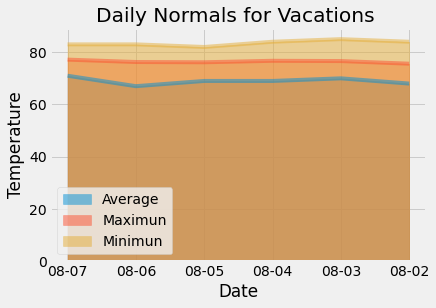

In [64]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot(kind='area',x='Date',stacked=False)
plt.ylabel('Temperature')
plt.title(f'Daily Normals for Vacations ')
plt.savefig('Images/daily-normals.png',bbox_inches='tight')

## Close Session

In [65]:
session.close()